## 第五节：特征工程进阶与方案优化

### 5.3 特征工程进阶实践

### 5.3.1 特征工程基础部分

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# 内存管理
import numpy as np
import pandas as pd
from tqdm import tqdm  

class _Data_Preprocess:
    def __init__(self):
        self.int8_max = np.iinfo(np.int8).max
        self.int8_min = np.iinfo(np.int8).min

        self.int16_max = np.iinfo(np.int16).max
        self.int16_min = np.iinfo(np.int16).min

        self.int32_max = np.iinfo(np.int32).max
        self.int32_min = np.iinfo(np.int32).min

        self.int64_max = np.iinfo(np.int64).max
        self.int64_min = np.iinfo(np.int64).min

        self.float16_max = np.finfo(np.float16).max
        self.float16_min = np.finfo(np.float16).min

        self.float32_max = np.finfo(np.float32).max
        self.float32_min = np.finfo(np.float32).min

        self.float64_max = np.finfo(np.float64).max
        self.float64_min = np.finfo(np.float64).min

    def _get_type(self, min_val, max_val, types):
        if types == 'int':
            if max_val <= self.int8_max and min_val >= self.int8_min:
                return np.int8
            elif max_val <= self.int16_max <= max_val and min_val >= self.int16_min:
                return np.int16
            elif max_val <= self.int32_max and min_val >= self.int32_min:
                return np.int32
            return None

        elif types == 'float':
            if max_val <= self.float16_max and min_val >= self.float16_min:
                return np.float16
            if max_val <= self.float32_max and min_val >= self.float32_min:
                return np.float32
            if max_val <= self.float64_max and min_val >= self.float64_min:
                return np.float64
            return None

    def _memory_process(self, df):
        init_memory = df.memory_usage().sum() / 1024 ** 2 / 1024
        print('Original data occupies {} GB memory.'.format(init_memory))
        df_cols = df.columns

          
        for col in tqdm_notebook(df_cols):
            try:
                if 'float' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val, max_val, 'float')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
                elif 'int' in str(df[col].dtypes):
                    max_val = df[col].max()
                    min_val = df[col].min()
                    trans_types = self._get_type(min_val, max_val, 'int')
                    if trans_types is not None:
                        df[col] = df[col].astype(trans_types)
            except:
                print(' Can not do any process for column, {}.'.format(col)) 
        afterprocess_memory = df.memory_usage().sum() / 1024 ** 2 / 1024
        print('After processing, the data occupies {} GB memory.'.format(afterprocess_memory))
        return df

In [ ]:
memory_process = _Data_Preprocess()

In [60]:
### 数据读取
path  = r'D:\Documents\天池竞赛\阿里云安全恶意程序检测\dataset\\'
train = pd.read_csv(path + 'security_train.csv')
test  = pd.read_csv(path + 'security_test.csv')

In [62]:
def simple_sts_features(df):
    simple_fea             = pd.DataFrame()
    simple_fea['file_id']  = df['file_id'].unique()
    simple_fea             = simple_fea.sort_values('file_id')
     
    df_grp = df.groupby('file_id')
    simple_fea['file_id_api_count']   = df_grp['api'].count().values
    simple_fea['file_id_api_nunique'] = df_grp['api'].nunique().values
    
    simple_fea['file_id_tid_count']   = df_grp['tid'].count().values
    simple_fea['file_id_tid_nunique'] = df_grp['tid'].nunique().values
    
    simple_fea['file_id_index_count']   = df_grp['index'].count().values
    simple_fea['file_id_index_nunique'] = df_grp['index'].nunique().values
    
    return simple_fea

In [139]:
%%time
simple_train_fea1 = simple_sts_features(train)

Wall time: 55.1 s


In [140]:
%%time
simple_test_fea1 = simple_sts_features(test)

Wall time: 46.6 s


In [65]:
def simple_numerical_sts_features(df):
    simple_numerical_fea             = pd.DataFrame()
    simple_numerical_fea['file_id']  = df['file_id'].unique()
    simple_numerical_fea             = simple_numerical_fea.sort_values('file_id')
     
    df_grp = df.groupby('file_id')
    
    simple_numerical_fea['file_id_tid_mean']  = df_grp['tid'].mean().values
    simple_numerical_fea['file_id_tid_min']   = df_grp['tid'].min().values
    simple_numerical_fea['file_id_tid_std']   = df_grp['tid'].std().values
    simple_numerical_fea['file_id_tid_max']   = df_grp['tid'].max().values
    
    
    simple_numerical_fea['file_id_index_mean']= df_grp['index'].mean().values
    simple_numerical_fea['file_id_index_min'] = df_grp['index'].min().values
    simple_numerical_fea['file_id_index_std'] = df_grp['index'].std().values
    simple_numerical_fea['file_id_index_max'] = df_grp['index'].max().values
    
    return simple_numerical_fea

In [66]:
%%time
simple_train_fea2 = simple_numerical_sts_features(train)

Wall time: 8.15 s


In [67]:
%%time
simple_test_fea2 = simple_numerical_sts_features(test)

Wall time: 6.36 s


### 5.3.2 特征工程进阶部分

In [150]:
def api_pivot_count_features(df):
    # 对输入的DataFrame进行分组，按照'file_id'和'api'进行分组，并计算每个分组中'tid'的出现次数
    tmp = df.groupby(['file_id','api'])['tid'].count().to_frame('api_tid_count').reset_index()
    # 使用pivot_table函数将分组后的数据转换为宽格式，以'file_id'为行索引，'api'为列索引，'api_tid_count'为值， fill_value参数设置为0，表示用0填充缺失值
    tmp_pivot = pd.pivot_table(data=tmp,index = 'file_id',columns='api',values='api_tid_count',fill_value=0)
    # 重命名列名，添加'_pivot_'前缀
    tmp_pivot.columns = [tmp_pivot.columns.names[0] + '_pivot_'+ str(col) for col in tmp_pivot.columns]
    tmp_pivot.reset_index(inplace = True)
    
    # 调用_memory_process函数进行内存处理
    tmp_pivot = memory_process._memory_process(tmp_pivot)
    return tmp_pivot

In [157]:
import pandas as pd


def align_columns(train_df, test_df):
    # 获取训练集和测试集的列名
    train_columns = set(train_df.columns)
    test_columns = set(test_df.columns)
    
    # 找出共有列
    common_columns = train_columns.intersection(test_columns)
    
    # 找出非共有列
    non_common_train_columns = train_columns - test_columns
    non_common_test_columns = test_columns - train_columns
    
    # 在训练集中添加测试集中独有的列，并填充0
    for col in non_common_test_columns:
        train_df[col] = 0
    
    # 在测试集中添加训练集中独有的列，并填充0
    for col in non_common_train_columns:
        test_df[col] = 0
    
    # 重新排序列，确保顺序一致
    all_columns = sorted(common_columns.union(non_common_train_columns, non_common_test_columns))
    train_df = train_df[all_columns]
    test_df = test_df[all_columns]
    
    return train_df, test_df

In [151]:
%%time
simple_train_fea3 = api_pivot_count_features(train)

Original data occupies 0.030626118183135986 GB memory.


  0%|          | 0/296 [00:00<?, ?it/s]

After processing, the data occupies 0.012209132313728333 GB memory.
Wall time: 14.8 s


In [152]:
%%time
simple_test_fea3 = api_pivot_count_features(test)

Original data occupies 0.02886027842760086 GB memory.


  0%|          | 0/299 [00:00<?, ?it/s]

After processing, the data occupies 0.011425943113863468 GB memory.
Wall time: 12.9 s


In [158]:

# 对齐训练集和测试集的列
simple_train_fea3, simple_test_fea3 = align_columns(simple_train_fea3, simple_test_fea3)

In [159]:
def tmp(a,b):
    # test_submit.columns.values
    train_columns = set(a.columns)
    test_columns = set(b.columns)
    common_columns = train_columns.symmetric_difference(test_columns)
    print(list(common_columns))

tmp(simple_train_fea3,simple_test_fea3)

[]


In [72]:
def api_pivot_nunique_features(df):
    tmp = df.groupby(['file_id','api'])['tid'].nunique().to_frame('api_tid_nunique').reset_index()
    tmp_pivot = pd.pivot_table(data=tmp,index = 'file_id',columns='api',values='api_tid_nunique',fill_value=0)
    tmp_pivot.columns = [tmp_pivot.columns.names[0] + '_pivot_'+ str(col) for col in tmp_pivot.columns]
    tmp_pivot.reset_index(inplace = True)
    tmp_pivot = memory_process._memory_process(tmp_pivot)
    return tmp_pivot 

In [73]:
%%time
simple_train_fea4 = api_pivot_count_features(train)

Original data occupies 0.030626118183135986 GB memory.


  0%|          | 0/296 [00:00<?, ?it/s]

After processing, the data occupies 0.012209132313728333 GB memory.
Wall time: 14.3 s


In [75]:
%%time
simple_test_fea4 = api_pivot_count_features(test)

Original data occupies 0.02886027842760086 GB memory.


  0%|          | 0/299 [00:00<?, ?it/s]

After processing, the data occupies 0.011425943113863468 GB memory.
Wall time: 12.4 s


In [160]:
simple_train_fea4, simple_test_fea4 = align_columns(simple_train_fea4, simple_test_fea4)

In [161]:
def tmp(a,b):
    train_columns = set(a.columns)
    test_columns = set(b.columns)
    common_columns = train_columns.symmetric_difference(test_columns)
    print(list(common_columns))

tmp(simple_train_fea4,simple_test_fea4)

[]


In [162]:
train_data = train[['file_id','label']].drop_duplicates(subset = ['file_id','label'], keep = 'first')
test_submit = test[['file_id']].drop_duplicates(subset = ['file_id'], keep = 'first')

In [163]:
train_data = train_data.merge(simple_train_fea1, on ='file_id', how='left')
train_data = train_data.merge(simple_train_fea2, on ='file_id', how='left')
train_data = train_data.merge(simple_train_fea3, on ='file_id', how='left')
train_data = train_data.merge(simple_train_fea4, on ='file_id', how='left')

In [164]:
test_submit = test_submit.merge(simple_test_fea1, on ='file_id', how='left')
test_submit = test_submit.merge(simple_test_fea2, on ='file_id', how='left')
test_submit = test_submit.merge(simple_test_fea3, on ='file_id', how='left')
test_submit = test_submit.merge(simple_test_fea4, on ='file_id', how='left')

In [165]:
### 评估指标构建
def lgb_logloss(preds,data):
    labels_ = data.get_label()             
    classes_ = np.unique(labels_) 
    preds_prob = []
    for i in range(len(classes_)):
        preds_prob.append(preds[i*len(labels_):(i+1) * len(labels_)] )
        
    preds_prob_ = np.vstack(preds_prob) 
    
    loss = []
    for i in range(preds_prob_.shape[1]):     
        sum_ = 0
        for j in range(preds_prob_.shape[0]): 
            pred = preds_prob_[j,i]           
            if  j == labels_[i]:
                sum_ += np.log(pred)
            else:
                sum_ += np.log(1 - pred)
        loss.append(sum_)       
    return 'loss is: ',-1 * (np.sum(loss) / preds_prob_.shape[1]),False

### 5.3.3 基于LightGBM 的模型验证

In [166]:
train_features = [col for col in train_data.columns if col not in ['label','file_id']]
train_label    = 'label'

In [167]:
%%time
from sklearn.model_selection import StratifiedKFold,KFold
params = {
        'task':'train', 
        'num_leaves': 255,
        'objective': 'multiclass',
        'num_class': 8,
        'min_data_in_leaf': 50,
        'learning_rate': 0.05,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5, 
        'max_bin':128,
        'random_state':100
    }   

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))

predict_res = 0
models = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_data.iloc[trn_idx][train_features], label=train_data.iloc[trn_idx][train_label].values)
    val_data = lgb.Dataset(train_data.iloc[val_idx][train_features], label=train_data.iloc[val_idx][train_label].values) 
    
    clf = lgb.train(params, trn_data, num_boost_round=2000,valid_sets=[trn_data,val_data], verbose_eval=50, early_stopping_rounds=100, feval=lgb_logloss) 
    models.append(clf)

fold n°0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31672
[LightGBM] [Info] Number of data points in the train set: 11109, number of used features: 485
[LightGBM] [Info] Start training from score -1.029745
[LightGBM] [Info] Start training from score -3.344249
[LightGBM] [Info] Start training from score -2.487882
[LightGBM] [Info] Start training from score -2.805253
[LightGBM] [Info] Start training from score -4.861164
[LightGBM] [Info] Start training from score -1.173157
[LightGBM] [Info] Start training from score -3.277640
[LightGBM] [Info] Start training from score -2.214659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

<AxesSubplot:>

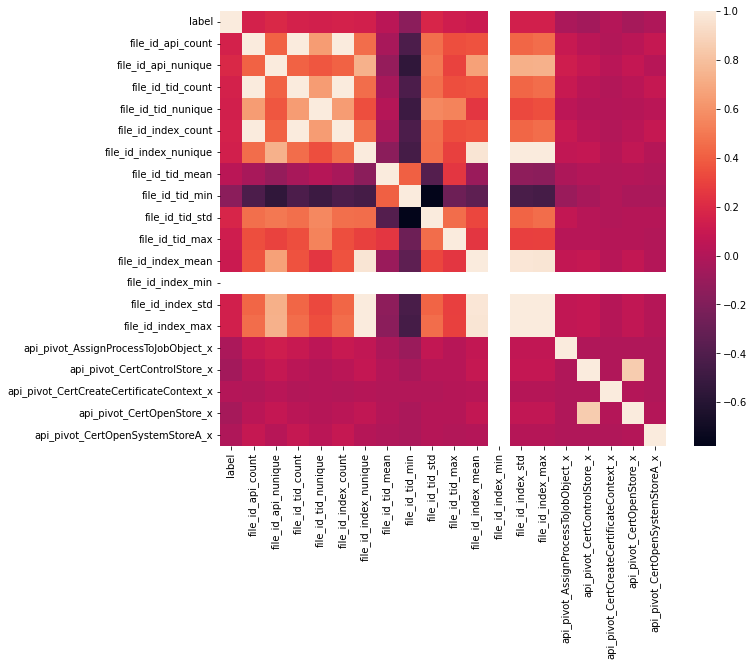

In [168]:
plt.figure(figsize=[10,8])
sns.heatmap(train_data.iloc[:10000, 1:21].corr())

因此，颜色越深的单元格表示对应的两个变量之间的相关性越弱。

In [169]:
### 特征重要性分析
feature_importance             = pd.DataFrame()
feature_importance['fea_name'] = train_features
feature_importance['fea_imp']  = clf.feature_importance()
feature_importance             = feature_importance.sort_values('fea_imp',ascending = False)

In [170]:
feature_importance.sort_values('fea_imp',ascending = False)

,fea_name,fea_imp
6,file_id_tid_mean,3702
148,api_pivot_LdrGetProcedureAddress_x,3335
9,file_id_tid_max,3308
8,file_id_tid_std,3034
7,file_id_tid_min,2990
...,...,...
570,api_pivot_SetInformationJobObject_y,0
233,api_pivot_RegDeleteValueA_x,0
313,api_pivot_system_x,0
232,api_pivot_RegDeleteKeyW_x,0


<AxesSubplot:xlabel='fea_name', ylabel='fea_imp'>

<Figure size 1440x720 with 0 Axes>

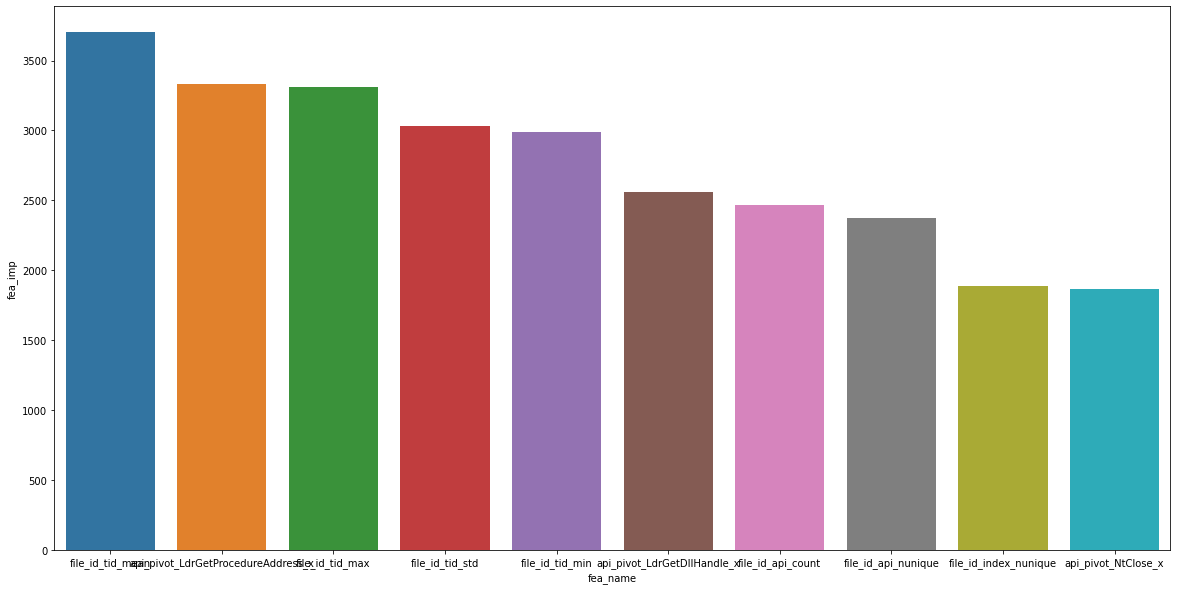

In [171]:
plt.figure(figsize=[20, 10,])
plt.figure(figsize=[20, 10,])
sns.barplot(x = feature_importance.iloc[:10]['fea_name'], y = feature_importance.iloc[:10]['fea_imp'])

<AxesSubplot:xlabel='fea_name', ylabel='fea_imp'>

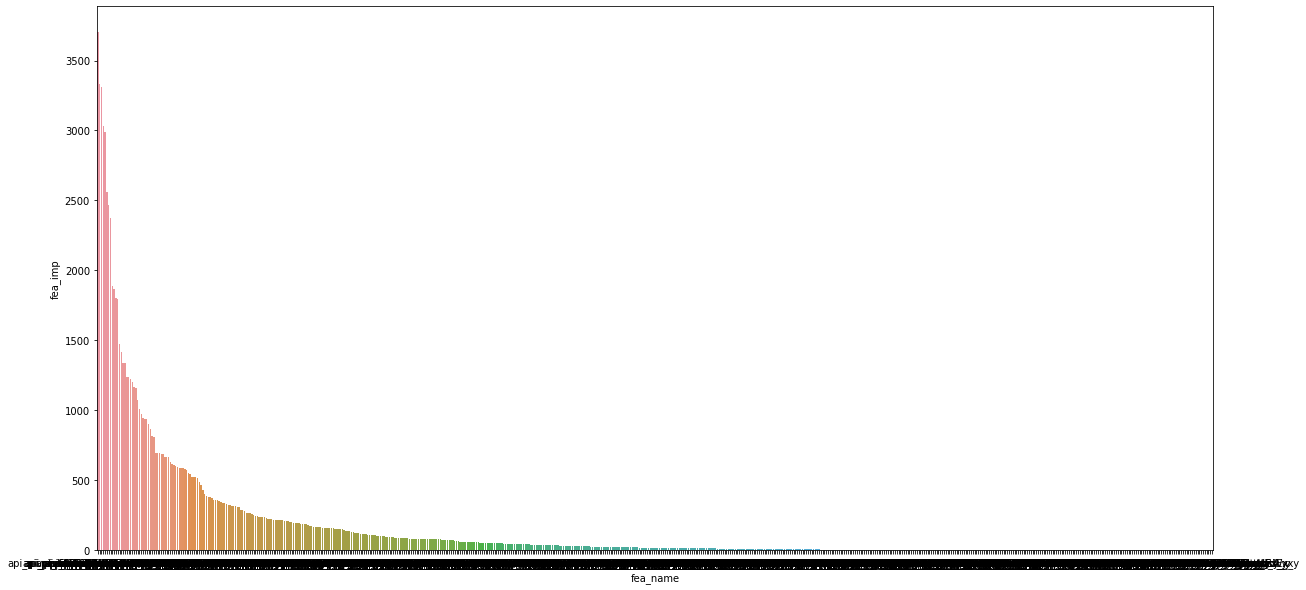

In [172]:
plt.figure(figsize=[20, 10,])
sns.barplot(x = feature_importance['fea_name'], y = feature_importance['fea_imp'])

### 5.3.5 模型测试

In [ ]:
pred_res = 0
flod = 5
for model in models:
    pred_res += model.predict(test_submit[train_features]) * 1.0 / flod

test_submit['prob0'] = 0
test_submit['prob1'] = 0
test_submit['prob2'] = 0
test_submit['prob3'] = 0
test_submit['prob4'] = 0
test_submit['prob5'] = 0
test_submit['prob6'] = 0
test_submit['prob7'] = 0

test_submit[['prob0','prob1','prob2','prob3','prob4','prob5','prob6','prob7']] = pred_res
test_submit[['file_id','prob0','prob1','prob2','prob3','prob4','prob5','prob6','prob7']].to_csv('baseline2.csv',index = None)

In [176]:
test_submit[['file_id','prob0','prob1','prob2','prob3','prob4','prob5','prob6','prob7']]

,file_id,prob0,prob1,prob2,prob3,prob4,prob5,prob6,prob7
0,1,0.003589,0.001410,0.952411,0.014093,0.000770,0.012563,0.003732,0.011432
1,2,0.769831,0.001179,0.003038,0.005015,0.000407,0.165543,0.009627,0.045360
2,3,0.998020,0.000089,0.000259,0.000188,0.000018,0.000799,0.000104,0.000522
3,4,0.034775,0.004740,0.015003,0.073180,0.002210,0.630724,0.032125,0.207242
4,5,0.979456,0.000380,0.003017,0.001776,0.000108,0.009353,0.000776,0.005132
...,...,...,...,...,...,...,...,...,...
12950,12951,0.933010,0.047483,0.002114,0.000784,0.000077,0.012771,0.000594,0.003166
12951,12952,0.988534,0.000274,0.001007,0.001157,0.000227,0.006499,0.000352,0.001950
12952,12953,0.002017,0.000501,0.000598,0.000923,0.000048,0.992145,0.000626,0.003143
12953,12954,0.001194,0.000119,0.000278,0.000212,0.000034,0.996943,0.000191,0.001029
